ctrl shift f10 - search commands

In [ ]:
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

# Imports

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib


In [ ]:
from tensorflow import keras
from tensorflow.keras import activations, regularizers, layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.debugging.set_log_device_placement(False)

Num GPUs Available:  1


In [ ]:
filetype = "Segmented"
numcode = 20

# Getting the data

terminate session - ram disk 3 dots, manage session, terminate

In [ ]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
!unzip '/content/gdrive/MyDrive/Project Final year/Grapes_1.zip'

Streaming output truncated to the last 5000 lines.
  inflating: Grapes_1/Test/Color/Esca/Low/191__Color__Esca__Low.JPG  
  inflating: Grapes_1/Test/Color/Esca/Low/192__Color__Esca__Low.JPG  
  inflating: Grapes_1/Test/Color/Esca/Low/193__Color__Esca__Low.JPG  
  inflating: Grapes_1/Test/Color/Esca/Low/194__Color__Esca__Low.JPG  
  inflating: Grapes_1/Test/Color/Esca/Low/195__Color__Esca__Low.JPG  
  inflating: Grapes_1/Test/Color/Esca/Low/196__Color__Esca__Low.JPG  
  inflating: Grapes_1/Test/Color/Esca/Low/197__Color__Esca__Low.JPG  
  inflating: Grapes_1/Test/Color/Esca/Low/198__Color__Esca__Low.JPG  
  inflating: Grapes_1/Test/Color/Esca/Low/199__Color__Esca__Low.JPG  
  inflating: Grapes_1/Test/Color/Esca/Low/200__Color__Esca__Low.JPG  
  inflating: Grapes_1/Test/Color/Esca/Low/201__Color__Esca__Low.JPG  
  inflating: Grapes_1/Test/Color/Esca/Low/202__Color__Esca__Low.JPG  
  inflating: Grapes_1/Test/Color/Esca/Low/203__Color__Esca__Low.JPG  
  inflating: Grapes_1/Test/Color/Esca/L

# temp - count

In [ ]:
xpath = '/content/Grapes_1/Train/'+ filetype + '/Healthy/No label'
data_dir = pathlib.Path(xpath)
print(len(list(data_dir.glob('*'))))


380


In [ ]:
xpath = '/content/Grapes_1/Train/'

In [ ]:
import os
c = 0
for folder, subfolders, filenames in os.walk(xpath):
    c += len(filenames)
print(c)

4580


# Some functions

In [ ]:
def get_label(file_path, class_names):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The fourth to last is the class-directory
  one_hot = parts[-3] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)



In [ ]:
def decode_img(img, img_height, img_width):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])


In [ ]:
def process_path(file_path):
  label = get_label(file_path, class_names)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img, img_height, img_width)
  return img, label


In [ ]:
def getfiles(srcpath):
  lfiles = []
  for fol, subfol, files in os.walk(srcpath):
    for file in files:
      lfiles.append(os.path.join(srcpath, os.path.relpath(file)))
  return lfiles

In [ ]:
def getinput(src, image_count):
  list_ds = tf.data.Dataset.list_files(str(src), shuffle=True)
  list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=True)
  val_size = int(image_count * 0.2)
  print(src, 'val size', val_size)
  train_ds = list_ds.skip(val_size)
  val_ds = list_ds.take(val_size)
  print(src, '# train', tf.data.experimental.cardinality(train_ds).numpy())
  print(src, '# test', tf.data.experimental.cardinality(val_ds).numpy())


In [ ]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

In [ ]:
def pred(imgpath):
  img = tf.keras.utils.load_img(
      os.path.abspath(imgpath), target_size=(img_height, img_width)
  )
  img_array = tf.keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch

  predictions = head_model.predict(img_array)
  score = tf.nn.softmax(predictions[0])

  print(
      " {} with a {:.2f} percent confidence."
      .format(class_names[np.argmax(score)], 100 * np.max(score))
  )
  return class_names[np.argmax(score)]

In [ ]:
def test_acc(srcpath, classlabel):
  c = 0
  for i in srcpath:
    # print(i, pred(i))
    if classlabel == pred(i):
      c += 1
  return c

# Some parameters

In [ ]:
batch_size = 32
img_height = 229
img_width = 229


In [ ]:
xpath = '/content/Grapes_1/Train/'+ filetype 
data_dir = pathlib.Path(xpath)
print(len(list(data_dir.glob('*'))))


4


# Preparing data

In [ ]:
image_count = 190 * 2
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*/*'), shuffle=True)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=True)

In [ ]:
temp_ds = tf.data.Dataset.list_files(str(data_dir/'*/*/*'), shuffle=False)
type(temp_ds)

tensorflow.python.data.ops.dataset_ops.TensorSliceDataset

In [ ]:
for f in list_ds.take(5):
  print(f.numpy())


b'/content/Grapes_1/Train/Segmented/Esca/Low/20__Segmented__Esca__Low.JPG'
b'/content/Grapes_1/Train/Segmented/Isariopsis/Low/48__Segmented__Isariopsis__Low.JPG'
b'/content/Grapes_1/Train/Segmented/Esca/Low/34__Segmented__Esca__Low.JPG'
b'/content/Grapes_1/Train/Segmented/Isariopsis/High/108__Segmented__Isariopsis__High.JPG'
b'/content/Grapes_1/Train/Segmented/Esca/Low/145__Segmented__Esca__Low.JPG'


In [ ]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)


['Black rot' 'Esca' 'Healthy' 'Isariopsis']


In [ ]:
val_size = int(image_count * 0.2)
print(val_size)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)


76


In [ ]:
print(type(train_ds))

<class 'tensorflow.python.data.ops.dataset_ops.SkipDataset'>


In [ ]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())


1444
76


# Standardize the data

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
# total_ds = temp_ds.cache().prefetch(buffer_size=AUTOTUNE)



In [ ]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE).shuffle(buffer_size= image_count )
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)
total_ds = temp_ds.map(process_path)


In [ ]:
type(total_ds)

tensorflow.python.data.ops.dataset_ops.MapDataset

In [ ]:
height_factor = [0, 0.1] # between 20%, 30%
width_factor = [0, 0.1]
layer_zoom = tf.keras.layers.RandomZoom(
    height_factor, width_factor=None, fill_mode='reflect',
    interpolation='bilinear', seed=None, fill_value=0.0
)
train_ds = train_ds.map(lambda x, y: (layer_zoom(x), y))
val_ds = val_ds.map(lambda x, y: (layer_zoom(x), y))

factor = [0, 0.05]
layer_rot = tf.keras.layers.RandomRotation(
    factor, fill_mode='reflect', interpolation='bilinear',
    seed=None, fill_value=0.0
)
train_ds = train_ds.map(lambda x, y: (layer_rot(x), y))
val_ds = val_ds.map(lambda x, y: (layer_rot(x), y))



In [ ]:
layer_train = tf.keras.layers.experimental.preprocessing.Normalization(axis=None)
train_ds = train_ds.map(lambda x, y: (layer_train(x), y))
# train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(lambda x, y: (layer_train(x), y))
# val_ds = val_ds.prefetch(tf.data.AUTOTUNE)


In [ ]:
for image, label in train_ds.take(5):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (229, 229, 3)
Label:  3
Image shape:  (229, 229, 3)
Label:  2
Image shape:  (229, 229, 3)
Label:  2
Image shape:  (229, 229, 3)
Label:  2
Image shape:  (229, 229, 3)
Label:  2


# Model

In [ ]:
base_model = tf.keras.applications.densenet.DenseNet201(
    include_top=False, weights='imagenet', classes=class_names, input_shape = (img_height, img_width, 3)
)

In [ ]:
x = layers.Flatten()(base_model.output)
x = layers.Dense(1000, activation='relu')(x)
predictions = layers.Dense(len(class_names), activation = 'softmax')(x)

head_model = Model(inputs = base_model.input, outputs = predictions)
head_model.compile(optimizer='adam', loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

In [ ]:
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

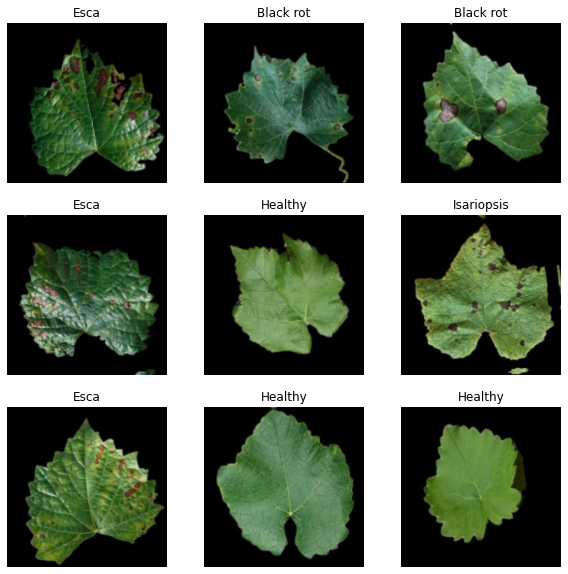

In [ ]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")


# Train

In [ ]:
# callbacks = [
#     keras.callbacks.EarlyStopping(
#         # Stop training when `val_loss` is no longer improving
#         monitor="val_loss",
#         # "no longer improving" being defined as "no better than 1e-2 less"
#         min_delta=1e-2,
#         # "no longer improving" being further defined as "for at least 2 epochs"
#         patience=2,
#         verbose=1,
#     )
# ]

# model.fit(
#     x_train,
#     y_train,
#     epochs=20,
#     batch_size=64,
#     callbacks=callbacks,
#     validation_split=0.2,
# )


In [ ]:
epochs=75
# history = model.fit(
#   train_ds,
#   validation_data=val_ds,
#   epochs=epochs
# )
history = head_model.fit(train_ds, batch_size = batch_size, epochs=epochs, validation_data=val_ds)
# history = head_model.fit(train_ds, batch_size = batch_size, epochs=epochs, callbacks=callbacks, validation_data=val_ds)


Epoch 1/75
46/46 [==============================] - 118s 2s/step - loss: 7.1664 - accuracy: 0.8345 - val_loss: 1305.0358 - val_accuracy: 0.2500
Epoch 2/75
46/46 [==============================] - 59s 1s/step - loss: 0.6894 - accuracy: 0.9515 - val_loss: 67628.0625 - val_accuracy: 0.3026
Epoch 3/75
46/46 [==============================] - 59s 1s/step - loss: 2.6223 - accuracy: 0.8843 - val_loss: 25878.0527 - val_accuracy: 0.2632
Epoch 4/75
46/46 [==============================] - 58s 1s/step - loss: 1.8039 - accuracy: 0.8082 - val_loss: 77233.5469 - val_accuracy: 0.2500
Epoch 5/75
46/46 [==============================] - 59s 1s/step - loss: 0.9004 - accuracy: 0.9037 - val_loss: 2659.5593 - val_accuracy: 0.4211
Epoch 6/75
46/46 [==============================] - 58s 1s/step - loss: 0.3124 - accuracy: 0.9335 - val_loss: 271.7250 - val_accuracy: 0.5132
Epoch 7/75
46/46 [==============================] - 58s 1s/step - loss: 2.4885 - accuracy: 0.8657 - val_loss: 543263.5000 - val_accuracy: 0

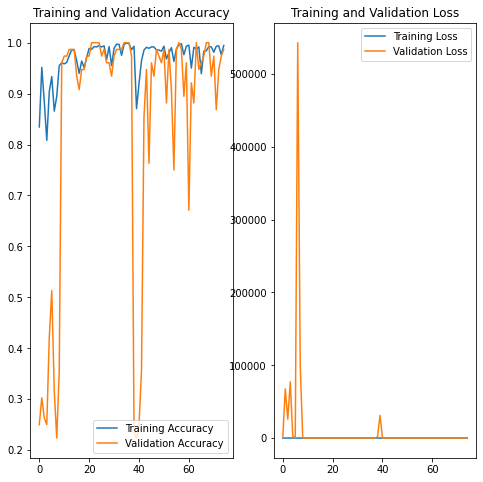

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [ ]:
print(acc, val_acc)

[0.8344875574111938, 0.9515235424041748, 0.8843490481376648, 0.8081717491149902, 0.9037396311759949, 0.9335179924964905, 0.8656509518623352, 0.8947368264198303, 0.9549861550331116, 0.9605262875556946, 0.9584487676620483, 0.9612188339233398, 0.9743767380714417, 0.9861496090888977, 0.9847645163536072, 0.9646814465522766, 0.9397506713867188, 0.9639889001846313, 0.9508309960365295, 0.9709141254425049, 0.9889196753501892, 0.9868420958518982, 0.992382287979126, 0.9916897416114807, 0.9944598078727722, 0.9916897416114807, 0.9937673211097717, 0.9667590260505676, 0.992382287979126, 0.9549861550331116, 0.9889196753501892, 0.9972299337387085, 0.9965373873710632, 0.9750692248344421, 0.9965373873710632, 0.9993074536323547, 0.997922420501709, 0.9861496090888977, 0.9930747747421265, 0.8704985976219177, 0.9196676015853882, 0.9646814465522766, 0.9854570627212524, 0.9909972548484802, 0.9889196753501892, 0.9916897416114807, 0.9916897416114807, 0.9854570627212524, 0.9854570627212524, 0.9833794832229614, 0.

# Save and load methods

In [ ]:
head_model.save('final_note'+ str(numcode) +'_1_densenet_'+ filetype + '.h5')


In [ ]:
head_model.save('/content/drive/MyDrive/final_note'+ str(numcode) +'_1_densenet_'+ filetype + '.h5')


In [ ]:
head_model.save_weights('/content/drive/MyDrive/checkpoints/my_checkpoint'+ str(numcode) +'_1_densenet_'+ filetype )

In [ ]:
# for pytorch
# import torch
# model_save_name = 'torch_state_grapes_densenet_segmented_1.pt'
# path = F"/content/gdrive/My Drive/{model_save_name}" 
# torch.save(head_model.state_dict(), path)

# model_save_name = 'classifier.pt'
# path = F"/content/gdrive/My Drive/{model_save_name}"
# model.load_state_dict(torch.load(path))

In [ ]:
# # Save the weights
head_model.save_weights('./checkpoints/my_checkpoint'+ str(numcode) +'_1_densenet_'+ filetype )

# # Create a new model instance
# # model = create_model()

# # Restore the weights
# # model.load_weights('./checkpoints/my_checkpoint10')

# # Evaluate the model
# # loss, acc = model.evaluate(test_images, test_labels, verbose=2)
# # print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

# model2 = tf.keras.Sequential([
#   data_augmentation,
#   tf.keras.layers.Rescaling(1./255),
#   ----
#   tf.keras.layers.MaxPooling2D(),
#   layers.Dropout(0.2),
#   tf.keras.layers.Flatten(),
#   tf.keras.layers.Dense(128, activation='relu'),
#   tf.keras.layers.Dense(num_classes)
# ])

# # Restore the weights
# model2.load_weights('./checkpoints/my_checkpoint10')


In [ ]:
# try:
#   from google.colab import files
# except Exception:
#   pass
# else:
#   files.download('final_note'+ str(numcode) +'_1_densenet_'+ filetype + '.h5')
#   files.download('./checkpoints/my_checkpoint'+ str(numcode) +'_1_densenet_'+ filetype+'/*')

# Test

In [ ]:
tpath = '/content/Grapes_1/Test/'+ filetype + '/Healthy/No label/419__'+ filetype + '__Healthy.JPG'
#tpath = '/content/adi shankaracharya/Test/Black rot/GrayScale/High/202__GrayScale__High.JPG'
# tpath = '/content/adi shankaracharya/Test/Esca/Color/High/466__Color__High.JPG'
img = tf.keras.utils.load_img(
    tpath, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = head_model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


This image most likely belongs to Healthy with a 47.53 percent confidence.


In [ ]:
print(score)

tf.Tensor([0.17488185 0.1748823  0.4753445  0.17489135], shape=(4,), dtype=float32)


In [ ]:
diseases = ['Esca', 'Isariopsis', 'Black rot']
imgtypes = [ filetype ]
# imgtypes = ['Color', 'GrayScale', 'Segmented']
severity = ['Low', 'High']
filesdict = {}
for disease in diseases:
  for imgtype in imgtypes:
    for sev in severity:
      srcpath = os.path.join(r'/content/Grapes_1/Test', imgtype+ "//"+disease+"//"+ sev)
      # print(getfiles(srcpath))
      filesdict[disease+imgtype+sev] = [disease, getfiles(srcpath)]

In [ ]:
(10+10+10+10+9+8.5+10+10)/80

0.96875

In [ ]:
for k, v in filesdict.items():
  count_ = test_acc(v[1], v[0])
  print(k, count_, count_/len(v))

 Esca with a 47.54 percent confidence.
 Esca with a 47.54 percent confidence.
 Esca with a 47.54 percent confidence.
 Esca with a 47.54 percent confidence.
 Esca with a 47.54 percent confidence.
 Esca with a 47.54 percent confidence.
 Esca with a 47.54 percent confidence.
 Esca with a 47.54 percent confidence.
 Esca with a 47.54 percent confidence.
 Esca with a 47.54 percent confidence.
 Esca with a 47.54 percent confidence.
 Esca with a 47.54 percent confidence.
 Esca with a 47.54 percent confidence.
 Esca with a 47.53 percent confidence.
 Esca with a 47.54 percent confidence.
 Esca with a 47.54 percent confidence.
 Esca with a 47.54 percent confidence.
 Esca with a 47.54 percent confidence.
 Esca with a 47.54 percent confidence.
 Esca with a 47.54 percent confidence.
EscaSegmentedLow 20 10.0
 Esca with a 47.54 percent confidence.
 Esca with a 47.54 percent confidence.
 Esca with a 47.54 percent confidence.
 Esca with a 47.54 percent confidence.
 Esca with a 47.54 percent confidence.


In [ ]:
# imgtypes = ['Color', 'GrayScale', 'Segmented']
imgtypes = [ filetype ]
filesdict = {}
for imgtype in imgtypes:
  srcpath = os.path.join(r'/content/Grapes_1/Test', imgtype+"//Healthy"+"//No label")
  filesdict[imgtype] = [disease, getfiles(srcpath)]
for k, v in filesdict.items():
  count_ = test_acc(v[1], "Healthy")
  print(k, count_, count_/len(v))

 Healthy with a 47.54 percent confidence.
 Healthy with a 47.54 percent confidence.
 Healthy with a 47.54 percent confidence.
 Healthy with a 47.53 percent confidence.
 Healthy with a 47.54 percent confidence.
 Healthy with a 47.54 percent confidence.
 Healthy with a 47.54 percent confidence.
 Healthy with a 47.48 percent confidence.
 Healthy with a 47.54 percent confidence.
 Healthy with a 47.53 percent confidence.
 Healthy with a 47.53 percent confidence.
 Healthy with a 47.54 percent confidence.
 Healthy with a 47.54 percent confidence.
 Healthy with a 47.53 percent confidence.
 Healthy with a 47.53 percent confidence.
 Healthy with a 47.54 percent confidence.
 Healthy with a 47.50 percent confidence.
 Healthy with a 47.53 percent confidence.
 Healthy with a 47.54 percent confidence.
 Healthy with a 47.54 percent confidence.
 Healthy with a 47.54 percent confidence.
 Healthy with a 47.54 percent confidence.
 Healthy with a 47.53 percent confidence.
 Healthy with a 47.53 percent conf

In [ ]:
# imgtypes = ['Color', 'GrayScale', 'Segmented']
imgtypes = [ filetype ]
filesdict = {}
for imgtype in imgtypes:
  srcpath = os.path.join(r'/content/Grapes_1/Test', imgtype+"//Healthy"+"//No label")
  filesdict[imgtype] = [disease, getfiles(srcpath)]
for k, v in filesdict.items():
  count_ = test_acc(v[1], "Healthy")
  print(k, count_, count_/len(v[1]))

 Healthy with a 47.54 percent confidence.
 Healthy with a 47.54 percent confidence.
 Healthy with a 47.54 percent confidence.
 Healthy with a 47.53 percent confidence.
 Healthy with a 47.54 percent confidence.
 Healthy with a 47.54 percent confidence.
 Healthy with a 47.54 percent confidence.
 Healthy with a 47.48 percent confidence.
 Healthy with a 47.54 percent confidence.
 Healthy with a 47.53 percent confidence.
 Healthy with a 47.53 percent confidence.
 Healthy with a 47.54 percent confidence.
 Healthy with a 47.54 percent confidence.
 Healthy with a 47.53 percent confidence.
 Healthy with a 47.53 percent confidence.
 Healthy with a 47.54 percent confidence.
 Healthy with a 47.50 percent confidence.
 Healthy with a 47.53 percent confidence.
 Healthy with a 47.54 percent confidence.
 Healthy with a 47.54 percent confidence.
 Healthy with a 47.54 percent confidence.
 Healthy with a 47.54 percent confidence.
 Healthy with a 47.53 percent confidence.
 Healthy with a 47.53 percent conf

In [ ]:
for folders, subfolders, files in os.walk(r'/content/Grapes_1/Test/'+ filetype + '/Low'):
  for tpath in files:
    img = tf.keras.utils.load_img(
        os.path.join('/content/Grapes_1/Test/Color/Low', tpath), target_size=(img_height, img_width)
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = head_model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    print('---')
    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score))
    )
    print(score)

In [ ]:
def store(sess_var, model_path):        
    if model_path is not None:
        saver = tf.train.Saver(var_list=tf.trainable_variables())
        save_path = saver.save(sess_var, model_path)
        print("Model saved in path: %s" % save_path)
    else:
        print("Model path is None - Nothing to store")



def restore(sess_var, model_path):
    if model_path is not None:
        if os.path.exists("{}.index".format(model_path)):
            saver = tf.train.Saver(var_list=tf.trainable_variables())
            saver.restore(sess_var, model_path)
            print("Model at %s restored" % model_path)
        else:
            print("Model path does not exist, skipping...")
    else:
        print("Model path is None - Nothing to restore")

In [ ]:
# !tar -czvf model.tar.gz models/

# Download the model:

# from google.colab import files
# files.download('model.tar.gz')

In [ ]:
!tar -czvf final20modelDensenet.tar.gz  /content/checkpoints/

tar: Removing leading `/' from member names
/content/checkpoints/
/content/checkpoints/checkpoint
/content/checkpoints/my_checkpoint20_1_densenet_Segmented.index
/content/checkpoints/my_checkpoint20_1_densenet_Segmented.data-00000-of-00001


In [ ]:
!tar -czvf final20modelDensenet_h5.tar.gz  /content/final_note20_1_densenet_Segmented.h5

tar: Removing leading `/' from member names
/content/final_note20_1_densenet_Segmented.h5


In [ ]:
# from google.colab import files
# files.download('final20modelDensenet.tar.gz')
# files.download('final20modelDensenet_h5.tar.gz')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>